# 1.Data Analysis and Preprocessing

## Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns

# PyTorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder

# Sklearn libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Ensure reproducibility
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Loaders

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception V3
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Define dataset paths
train_dir = '/kaggle/input/skin-data/data/train'
val_dir = '/kaggle/input/skin-data/data/val'
test_dir = '/kaggle/input/skin-data/data/test'

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2.Model Building

## Initialize Model

In [3]:
def initialize_model(num_classes, feature_extract=True, use_pretrained=True):
    """Initialize DenseNet model."""
    model = models.densenet121(weights="DEFAULT" if use_pretrained else None)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model
NUM_CLASSES = 5
model = initialize_model(NUM_CLASSES, feature_extract=False, use_pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Define Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3.Model Training

In [5]:
class AverageMeter:
    """Track and compute the average value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(train_loader, model, criterion, optimizer, epoch):
    """Training loop."""
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        prediction = outputs.argmax(dim=1, keepdim=True)
        correct = prediction.eq(labels.view_as(prediction)).sum().item()
        train_acc.update(correct / labels.size(0))
        train_loss.update(loss.item())

    return train_loss.avg, train_acc.avg

def validate(val_loader, model, criterion):
    """Validation loop."""
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            prediction = outputs.argmax(dim=1, keepdim=True)
            correct = prediction.eq(labels.view_as(prediction)).sum().item()
            val_acc.update(correct / labels.size(0))
            val_loss.update(loss.item())

    return val_loss.avg, val_acc.avg

## Start Training

In [6]:
epochs = 5
total_loss_train, total_acc_train = [], []
total_loss_val, total_acc_val = [], []

for epoch in range(1, epochs + 1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion)

    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    print(f"Epoch {epoch}, Train Loss: {loss_train:.4f}, Train Acc: {acc_train:.4f}, Val Loss: {loss_val:.4f}, Val Acc: {acc_val:.4f}")

Epoch 1, Train Loss: 0.4523, Train Acc: 0.8402, Val Loss: 0.2496, Val Acc: 0.9131
Epoch 2, Train Loss: 0.2167, Train Acc: 0.9274, Val Loss: 0.1998, Val Acc: 0.9217
Epoch 3, Train Loss: 0.1317, Train Acc: 0.9548, Val Loss: 0.3110, Val Acc: 0.9152
Epoch 4, Train Loss: 0.1231, Train Acc: 0.9576, Val Loss: 0.1108, Val Acc: 0.9643
Epoch 5, Train Loss: 0.0627, Train Acc: 0.9796, Val Loss: 0.0819, Val Acc: 0.9790


# 4.Model Evaluation

Test Loss: 0.1608, Test Accuracy: 0.9540
Confusion Matrix:
[[246   4   3   0   0]
 [  3 300  11   2   1]
 [  0   1 197   2   1]
 [  0   1   6 108   0]
 [  0   6   3   0  61]]


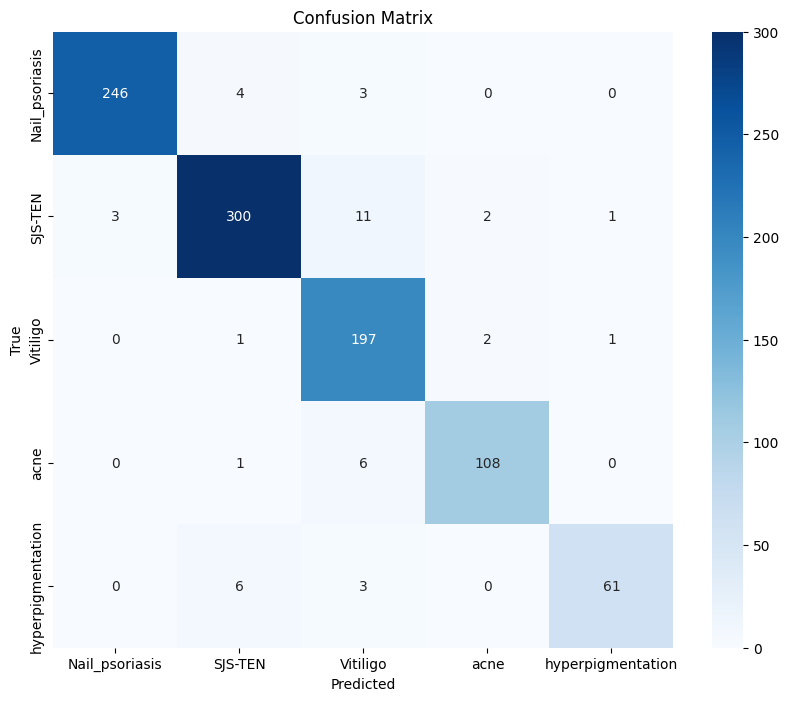

Classification Report:
                   precision    recall  f1-score   support

   Nail_psoriasis       0.99      0.97      0.98       253
          SJS-TEN       0.96      0.95      0.95       317
         Vitiligo       0.90      0.98      0.94       201
             acne       0.96      0.94      0.95       115
hyperpigmentation       0.97      0.87      0.92        70

         accuracy                           0.95       956
        macro avg       0.96      0.94      0.95       956
     weighted avg       0.96      0.95      0.95       956



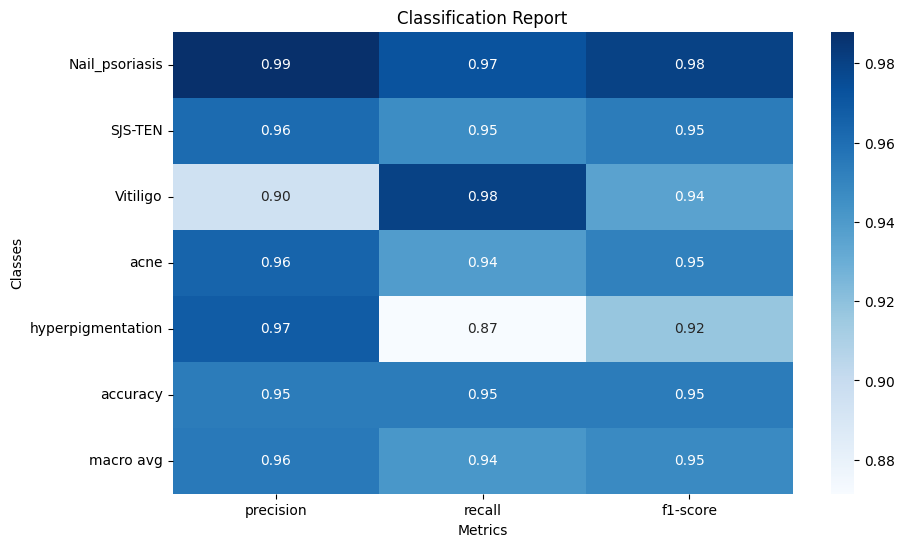

In [7]:
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure DATA_DIR is defined and points to the correct data folder
DATA_DIR = '/kaggle/input/skin-data/data'

# Define the test dataset and DataLoader
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=test_transform)
batch_size = 32
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the list of diseases (class labels)
diseases = test_dataset.classes

# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []

    total_loss = 0
    total_accuracy = 0

    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        test_outputs = model(images)
        test_loss = F.cross_entropy(test_outputs, labels)  # Calculate loss
        total_loss += test_loss.item()

        accuracy = (test_outputs.argmax(dim=1) == labels).float().mean()
        total_accuracy += accuracy.item()

        # Collect predictions and true labels for confusion matrix
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(test_outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dl)
    avg_accuracy = total_accuracy / len(test_dl)

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')
    # Convert to numpy arrays for further analysis
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    class_report_dict = classification_report(
        all_true_labels,
        all_predicted_labels,
        target_names=diseases,
        output_dict=True
    )
    print("Classification Report:")
    print(classification_report(all_true_labels, all_predicted_labels, target_names=diseases))

    # Plot classification report
    class_report_df = pd.DataFrame.from_dict(class_report_dict).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()


In [10]:
# saving to the kaggle working directory
PATH = './skin-disease-classification-DenseNet121.pth'  
torch.save(model.state_dict(), PATH)